In [1]:
### Import packages
import numpy as np 
# data processing
import pandas as pd 
# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import missingno as msno
### Analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
import shap

In [2]:
data = pd.read_pickle("data_knnimputed.pkl")
data=data.astype('category')

In [3]:
dummies=pd.get_dummies(data[['age_cat','education_cat','household','curfew_effective','curfew_compliance','gov_effect_econ','trust_fedgov','empl_status']],drop_first=True)
data = pd.concat([data.drop(['age_cat','education_cat','household','curfew_effective','curfew_compliance','gov_effect_econ','trust_fedgov','empl_status'],axis=1), dummies],axis=1)
data = data.astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3654 entries, 0 to 3764
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sex                    3654 non-null   category
 1   intention_to_vote      3654 non-null   category
 2   political_orientation  3654 non-null   category
 3   marstat                3654 non-null   category
 4   prob_gettinginfected   3654 non-null   category
 5   measures_adaptedwork   3654 non-null   category
 6   curfew_punish          3654 non-null   category
 7   sourceinfo_tradmedia   3654 non-null   category
 8   sourceinfo_localnewsp  3654 non-null   category
 9   sourceinfo_personal    3654 non-null   category
 10  choice_of_party        3654 non-null   category
 11  age_cat_2.0            3654 non-null   category
 12  age_cat_3.0            3654 non-null   category
 13  age_cat_4.0            3654 non-null   category
 14  education_cat_2.0      3654 non-null   c

Class=1, n=751 (20.553%)
Class=5, n=805 (22.031%)
Class=4, n=337 (9.223%)
Class=6, n=304 (8.320%)
Class=2, n=383 (10.482%)
Class=8, n=684 (18.719%)
Class=7, n=100 (2.737%)
Class=3, n=290 (7.937%)


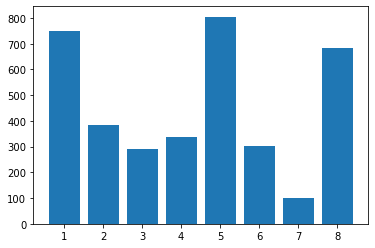

In [4]:
X=data.drop('choice_of_party', axis=1)
y=data['choice_of_party']
col_names = X.columns

counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [5]:
### SVM & ROC CURVE
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7, 8])
n_classes = y.shape[1]

In [6]:
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [7]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel="rbf", probability=False, random_state=random_state),n_jobs=-1)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [8]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

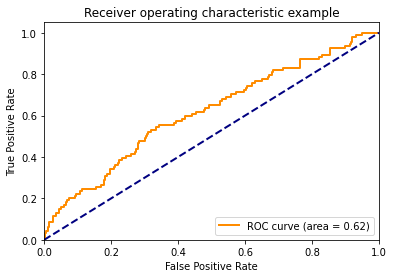

In [9]:
# Plot of a ROC curve for a specific class_ Class:2
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

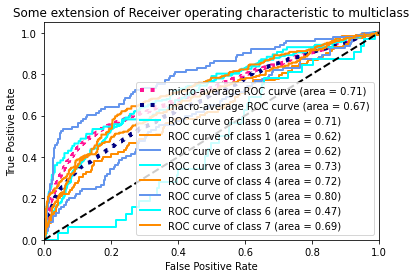

In [10]:
### Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size =0.3, stratify=y)
rf=RandomForestClassifier()
params_rf={'criterion':['gini','entropy'],'n_estimators':[100,200], 'max_depth':[3,4,5], 'min_samples_leaf':[1,2,3,5],'min_samples_split':[2,3,4,5], 'max_features':['auto','log2']}
grid_rf=GridSearchCV(estimator=rf, param_grid=params_rf,cv=10, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_hyper_rf=grid_rf.best_params_
print('Best hyperparameters\n', best_hyper_rf)
print('Best Score: %s' % grid_rf.best_score_)

In [ ]:
rf_bestmodel=RandomForestClassifier(criterion='gini', max_depth=5, max_features='auto', min_samples_leaf=3, min_samples_split=2, n_estimators=100, class_weight='balanced')
rf_bestmodel.fit(X_train,y_train)
y_bestpred=rf_bestmodel.predict(X_test)
print(classification_report(y_test,y_bestpred))

In [ ]:
#feature importance
feature_imp=pd.Series(rf_bestmodel.feature_importances_, col_names).sort_values()
feature_imp.plot(kind='barh')
plt.show()

In [ ]:
explainer = shap.TreeExplainer(rf_bestmodel)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, data.columns, plot_type="bar")